<a href="https://colab.research.google.com/github/redfear08/bot_trade_ml/blob/main/trading_bot_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install -q pandas scikit-learn tensorflow kiteconnect keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.5/771.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.4 MB/s eta 0:00:00


In [3]:
# Authentication and data fetching
import pandas as pd
from kiteconnect import KiteConnect
import datetime as dt
import time
import numpy as np

api_key = 'klz728yv89qrljzs'
api_secret = '4vhxunujbp17i8da0y1tiy7ayde4h5o8'
kite = KiteConnect(api_key=api_key)
print("Login URL:", kite.login_url())
request_token = input("Enter request token: ")
data = kite.generate_session(request_token, api_secret=api_secret)
access_token = data["access_token"]
kite.set_access_token(access_token)

# Fetch historical data
def fetch_historical_data(kite, instrument_token, start_date, end_date, interval, csv_filename):
    delta = dt.timedelta(days=60)
    current_date = start_date
    all_data = []

    while current_date < end_date:
        to_date = min(current_date + delta, end_date)
        data = kite.historical_data(instrument_token, current_date, to_date, interval)
        if data:
            all_data.extend(data)
        else:
            print(f"No data fetched for period {current_date} to {to_date}")
        current_date = to_date + dt.timedelta(days=1)
        time.sleep(1)  # Avoid hitting API rate limits

    if not all_data:
        print("No data fetched at all")
        return pd.DataFrame()

    df = pd.DataFrame(all_data)
    df.to_csv(csv_filename, mode='w', index=False, header=True)
    return df

# Fetch historical data
instrument_token = '256265'  # INFY
start_date = dt.datetime(2016, 1, 1)
end_date = dt.datetime(2023, 12, 31)
interval = 'minute'
csv_filename = 'historical_data.csv'

df = fetch_historical_data(kite, instrument_token, start_date, end_date, interval, csv_filename)
print("Data fetched:")
print(df.head())

if df.empty:
    print("The fetched data is empty. Exiting.")
    exit()

# Feature Engineering
def add_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    df['SMA_50'] = df['close'].rolling(window=50).mean()
    print("SMA_50 added:")
    print(df[['SMA_50']].head(60))

    df['SMA_200'] = df['close'].rolling(window=200).mean()
    print("SMA_200 added:")
    print(df[['SMA_200']].head(210))

    df['RSI'] = calculate_rsi(df, 14)
    print("RSI added:")
    print(df[['RSI']].head(20))

    df['Bollinger_Upper'], df['Bollinger_Lower'] = calculate_bollinger_bands(df, 20)
    print("Bollinger Bands added:")
    print(df[['Bollinger_Upper', 'Bollinger_Lower']].head(25))

    df['MACD'], df['MACD_Signal'] = calculate_macd(df)
    print("MACD added:")
    print(df[['MACD', 'MACD_Signal']].head(30))

    df['Stochastic_%K'], df['Stochastic_%D'] = calculate_stochastic_oscillator(df, 14)
    print("Stochastic Oscillator added:")
    print(df[['Stochastic_%K', 'Stochastic_%D']].head(20))

    df['Momentum'] = df['close'] / df['close'].shift(10) - 1
    print("Momentum added:")
    print(df[['Momentum']].head(15))

    df['VWAP'] = calculate_vwap(df)
    print("VWAP added:")
    print(df[['VWAP']].head(15))

    df['ATR'] = calculate_atr(df)
    print("ATR added:")
    print(df[['ATR']].head(15))

    df['Target'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)
    print("Target added:")
    print(df[['Target']].head(15))

    print("DataFrame before dropping NaNs:")
    print(df.head(220))

    df.dropna(subset=['Target'], inplace=True)
    print("DataFrame after dropping NaNs:")
    print(df.head(220))

    return df

def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(df, window=20):
    sma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    ema_12 = df['close'].ewm(span=short_window, adjust=False).mean()
    ema_26 = df['close'].ewm(span=long_window, adjust=False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic_oscillator(df, window=14):
    l14 = df['low'].rolling(window=window).min()
    h14 = df['high'].rolling(window=window).max()
    k = (df['close'] - l14) * 100 / (h14 - l14)
    d = k.rolling(window=3).mean()
    return k, d

def calculate_vwap(df):
    cum_tp_volume = (df['close'] * df['volume']).cumsum()
    cum_volume = df['volume'].cumsum()
    return cum_tp_volume / cum_volume

def calculate_atr(df, window=14):
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    tr = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

# Add features
df = add_features(df)
print("DataFrame with features:")
print(df.head())

if df.empty:
    print("The DataFrame after adding features is empty. Exiting.")
    exit()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

X_train = train_df[['SMA_50', 'SMA_200', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D', 'Momentum', 'VWAP']]
y_train = train_df['Target']

X_test = test_df[['SMA_50', 'SMA_200', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D', 'Momentum', 'VWAP']]
y_test = test_df['Target']

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

if X_train.empty or X_test.empty:
    print("Training or test set is empty. Exiting.")
    exit()

# Training Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import kerastuner as kt

# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning Function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))
    model.add(BatchNormalization())

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
        model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter Search
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='intro_to_kt')

tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
nn_model = tuner.hypermodel.build(best_hps)

# Check if a pre-trained model exists
model_path = 'best_nn_model.h5'
if os.path.exists(model_path):
    nn_model = load_model(model_path)
    print("Loaded pre-trained model.")
else:
    print("Created new model.")

# Continue training the model with early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

history = nn_model.fit(X_train_scaled, y_train,
                       epochs=200,
                       batch_size=64,
                       validation_split=0.1,
                       callbacks=[early_stopping, model_checkpoint],
                       verbose=1)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Model Accuracy: {accuracy}")

# Save Neural Network Model
nn_model.save(model_path)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Login URL: https://kite.zerodha.com/connect/login?api_key=klz728yv89qrljzs&v=3
Enter request token: 7D8lKVwjO0Y3M5dFjMC33Tu5HLxoRrz0
Data fetched:
                       date     open     high      low    close  volume
0 2016-01-01 09:15:00+05:30  7938.45  7939.25  7927.35  7927.95       0
1 2016-01-01 09:16:00+05:30  7928.65  7929.65  7926.40  7926.45       0
2 2016-01-01 09:17:00+05:30  7926.65  7927.70  7922.95  7923.05       0
3 2016-01-01 09:18:00+05:30  7923.20  7927.20  7923.20  7926.35       0
4 2016-01-01 09:19:00+05:30  7927.00  7927.50  7925.00  7925.05       0
SMA_50 added:
                             SMA_50
date                               
2016-01-01 09:15:00+05:30       NaN
2016-01-01 09:16:00+05:30       NaN
2016-01-01 09:17:00+05:30       NaN
2016-01-01 09:18:00+05:30       NaN
2016-01-01 09:19:00+05:30       NaN
2016-01-01 09:20:00+05:30       NaN
2016-01-01 09:21:00+05:30       NaN
2016-01-01 09:22:00+05:30       NaN
2016-01-01 09:23:00+05:30       NaN
2016-01-01 

<ipython-input-3-2b7f4651fb10>:187: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
448               |448               |units_input
0.1               |0.1               |dropout_input
1                 |1                 |num_layers
224               |224               |units_0
0.4               |0.4               |dropout_0
0.0001            |0.0001            |learning_rate

Epoch 1/10
16387/16387 [==============================] - 116s 7ms/step - loss: nan - accuracy: 0.5019 - val_loss: nan - val_accuracy: 0.5045
Epoch 2/10
16387/16387 [==============================] - 106s 6ms/step - loss: nan - accuracy: 0.5019 - val_loss: nan - val_accuracy: 0.5045
Epoch 3/10
16387/16387 [==============================] - 112s 7ms/step - loss: nan - accuracy: 0.5019 - val_loss: nan - val_accuracy: 0.5045
Epoch 4/10
16387/16387 [==============================] - 108s 7ms/step - loss: nan - accuracy: 0.5019 - val_loss: nan - val_accuracy: 0.5045
Epoch 5/10
16387/16387 [==============================

KeyboardInterrupt: 

In [24]:
X = df[['SMA_50', 'SMA_200', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D', 'Momentum', 'VWAP']]
y = df['Target']

In [6]:
# Training Random Forest Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy}")

# Save Random Forest Model
import joblib
joblib.dump(rf, 'best_rf_model.joblib')

Random Forest Model Accuracy: 0.5473940327026042


['best_rf_model.joblib']

Trial 10 Complete [00h 15m 07s]
val_accuracy: 0.5478023290634155

Best val_accuracy So Far: 0.5486099123954773
Total elapsed time: 04h 02m 18s
Loaded pre-trained model.
Epoch 1/200
8184/8184 [==============================] - 23s 3ms/step - loss: 0.6861 - accuracy: 0.5474 - val_loss: 0.6859 - val_accuracy: 0.5496
Epoch 2/200
  66/8184 [..............................] - ETA: 19s - loss: 0.6883 - accuracy: 0.5367

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8184/8184 [==============================] - 27s 3ms/step - loss: 0.6860 - accuracy: 0.5477 - val_loss: 0.6860 - val_accuracy: 0.5493
Epoch 3/200
8184/8184 [==============================] - 22s 3ms/step - loss: 0.6861 - accuracy: 0.5471 - val_loss: 0.6861 - val_accuracy: 0.5484
Epoch 4/200
8184/8184 [==============================] - 23s 3ms/step - loss: 0.6860 - accuracy: 0.5476 - val_loss: 0.6860 - val_accuracy: 0.5490
Epoch 5/200
8184/8184 [==============================] - 20s 2ms/step - loss: 0.6860 - accuracy: 0.5477 - val_loss: 0.6861 - val_accuracy: 0.5490
Epoch 6/200
8184/8184 [==============================] - 22s 3ms/step - loss: 0.6860 - accuracy: 0.5478 - val_loss: 0.6862 - val_accuracy: 0.5493
Epoch 7/200
8184/8184 [==============================] - 20s 2ms/step - loss: 0.6860 - accuracy: 0.5473 - val_loss: 0.6860 - val_accuracy: 0.5491
Epoch 8/200
8184/8184 [==============================] - 22s 3ms/step - loss: 0.6860 - accuracy: 0.5476 - val_loss: 0.6861 - val_accurac

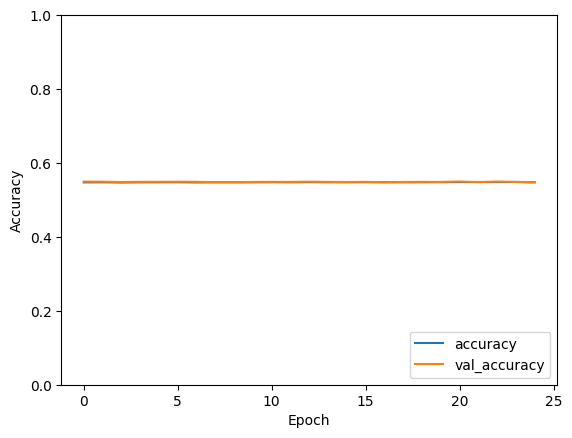

In [25]:
# Training Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import kerastuner as kt

# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning Function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))
    model.add(BatchNormalization())

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
        model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter Search
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,
                        executions_per_trial=1,
                        directory='my_dir',
                        project_name='intro_to_kt')

tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
nn_model = tuner.hypermodel.build(best_hps)

# Check if a pre-trained model exists
model_path = 'best_nn_model.h5'
if os.path.exists(model_path):
    nn_model = load_model(model_path)
    print("Loaded pre-trained model.")
else:
    print("Created new model.")

# Continue training the model with early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

history = nn_model.fit(X_train_scaled, y_train,
                       epochs=200,
                       batch_size=64,
                       validation_split=0.1,
                       callbacks=[early_stopping, model_checkpoint],
                       verbose=1)

# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Model Accuracy: {accuracy}")

# Save Neural Network Model
nn_model.save(model_path)



# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Backtesting Strategy with Balance Check, Stop Loss, and Target Profit
def backtest_strategy(model, data, initial_balance=100000, stop_loss_pct=0.02, target_profit_pct=0.05):
    balance = initial_balance
    position = None
    buy_price = 0
    trade_log = []

    for index, row in data.iterrows():
        if position is None:
            features = row[['SMA_50', 'SMA_200', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D', 'Momentum', 'VWAP']].values.reshape(1, -1)
            prediction = model.predict(features)[0]

            if prediction == 1:
                buy_price = row['close']
                position = 'long'
                trade_log.append((index, 'buy', buy_price))
                print(f"Buying at {buy_price}")

        elif position == 'long':
            current_price = row['close']
            if current_price <= buy_price * (1 - stop_loss_pct):
                balance -= (buy_price - current_price)
                position = None
                trade_log.append((index, 'stop_loss', current_price))
                print(f"Stop loss at {current_price}")
            elif current_price >= buy_price * (1 + target_profit_pct):
                balance += (current_price - buy_price)
                position = None
                trade_log.append((index, 'target_profit', current_price))
                print(f"Target profit at {current_price}")

    return balance, trade_log


In [ ]:

# Fetch historical data for backtest

# Authentication and data fetching
import pandas as pd
from kiteconnect import KiteConnect
import datetime as dt
import time
import numpy as np

api_key = 'klz728yv89qrljzs'
api_secret = '4vhxunujbp17i8da0y1tiy7ayde4h5o8'
kite = KiteConnect(api_key=api_key)
print("Login URL:", kite.login_url())
request_token = input("Enter request token: ")
data = kite.generate_session(request_token, api_secret=api_secret)
access_token = data["access_token"]
kite.set_access_token(access_token)

# Fetch historical data
def fetch_historical_data(kite, instrument_token, start_date, end_date, interval, csv_filename):
    delta = dt.timedelta(days=60)
    current_date = start_date
    all_data = []

    while current_date < end_date:
        to_date = min(current_date + delta, end_date)
        data = kite.historical_data(instrument_token, current_date, to_date, interval)
        all_data.extend(data)
        current_date = to_date + dt.timedelta(days=1)
        time.sleep(1)  # Avoid hitting API rate limits

    df = pd.DataFrame(all_data)
    df.to_csv(csv_filename, mode='w', index=False, header=True)
    return df

instrument_token = '738561' #INFY
start_date = dt.datetime(2017, 1, 1)
end_date = dt.datetime(2023, 12, 31)
interval = 'minute'
csv_filename = 'historical_data.csv'

df_backtest = fetch_historical_data(kite, instrument_token, start_date, end_date, interval, 'backtest_data.csv')
df_backtest = add_features(df_backtest)


NameError: name 'fetch_historical_data' is not defined

In [ ]:
# Perform Backtesting with Random Forest Model
final_balance, trade_log = backtest_strategy(rf, df_backtest)
print(f"Final Balance (Random Forest): {final_balance}")
print(trade_log)



In [ ]:
# Perform Backtesting with Neural Network Model
final_balance, trade_log = backtest_strategy(nn_model, df_backtest)
print(f"Final Balance (Neural Network): {final_balance}")
print(trade_log)